In [1]:
# Import libraries
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from econml.sklearn_extensions.linear_model import WeightedLassoCV
import sklearn.model_selection as sms
import sklearn.linear_model as slm
import sklearn.preprocessing as skp
import sklearn.metrics as sme
import sklearn.feature_selection as skf
import sklearn.ensemble as ske
import sklearn.utils as sku
import sklearn.decomposition as skd
import sklearn.neighbors as skn
from sklearn.exceptions import ConvergenceWarning
from celer import GroupLassoCV
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util
from scipy.spatial import cKDTree
import nibabel as nib
import os
import pickle
from torch import nn
patch_sklearn()

In [ ]:
HTML('''
<style>
.jupyter-matplotlib {
    background-color: #000;
}

.widget-label, .jupyter-matplotlib-header{
    color: #fff;
}

.jupyter-button {
    background-color: #333;
    color: #fff;
}
</style>
''')

In [ ]:
# Maybe y should also be scaled? 
# Perhaps a transform would be more effective, or scaling implemented with consistent cross-validation
# Different scaling methods? 
#     This seems most important for noise-sensitive models like LARS. All other use StandardScaler()
# Transformers?
# Model-specific scaling methods?
#     Yes, see above
# Common cross-validation function ✓
#     Use built-in functions wherever possible and `utils.gridsearch_pickparams()` elsewhere
# Quantile loss
# RANSAC
# Data augmentation? (Mixup)
# Data generation? (SMOGN)
# Combine CHH dataset ✓
# Implement CV and test ✓
# Print selected features ✓
# Make magnitude templates
# Sample weights ✓
# Look at segmentations by error ✓ (Appears to have most difference in red nucleus, which includes surrounding (white?) matter for underperforming cases)
# Extract features from current (1:6) eroded ROIs
# Extract features from all ROIs
# Plot segmentation variance against error for each case across all ROIs ✓
# Why does excluding the subthalamic nucleus increase the correlation (r=0.5 -> r=0.6)?
# Best performance with all ROIs: cvn=6, k=1800
# Best performance with ROIs 0:4, excluding STN: cvn=6, k=1800
# Should the pre-operative UPDRS be appended once or to each ROI? ✓
# Plot histogram of features for successful and unsuccessful predictions

In [ ]:
# Augment with CHH data
X0_gt = np.load('/home/ali/RadDBS-QSM/data/npy/old/X0_gt_chh_rois.npy')
df = pd.read_csv('/home/ali/RadDBS-QSM/data/xlxs/updrs_iii_chh.csv')
# Patient IDs
subject_id = np.asarray(df[df.columns[0]])[1:]
n_rois = 6
# Data
s_directory = open('/home/ali/RadDBS-QSM/data/roi/roi_list','r').read().splitlines()
# Load
with open('/home/ali/RadDBS-QSM/data/pickles/segs_chh', "rb") as fp:  
    segs = pickle.load(fp)
    n_cases = len(segs)
with open('/home/ali/RadDBS-QSM/data/pickles/qsms_chh', "rb") as fp:  
    qsms = pickle.load(fp)
with open('/home/ali/RadDBS-QSM/data/phi/chh/Phi_mcl_gt_roi_chh', "rb") as fp:  
    Phi_gt = pickle.load(fp)
L = int(len(X0_gt)/n_cases)
n_features = int(L/n_rois)
# Only extract ROI if it is present in all cases
seg_labels_all = segs[0]
case_number = np.zeros_like(np.asarray(s_directory))
for i in range(n_cases):
    case_number[i] = float(s_directory[i][-2:])
subject_id_corr = subject_id[np.in1d(subject_id,case_number)]
for i in range(n_cases):
    try:
        print('Found ROIs',str(np.unique(segs[i])),'at segmentation directory file',s_directory[i],'for case',str(subject_id_corr[i]))
    except:
        print('Case',subject_id[i],'quarantined')
pre_updrs_iii_off =  np.asarray(df[df.columns[3]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float)                             
pre_updrs_iii_on =  np.asarray(df[df.columns[4]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float) 
post_updrs_iii_off =  np.asarray(df[df.columns[6]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float) 

per_change = (pre_updrs_iii_off-post_updrs_iii_off)/pre_updrs_iii_off
pre_updrs_off = pre_updrs_iii_off
X_all_c = X0_gt.reshape(n_cases,n_rois,n_features)
X_all_c = X_all_c[:,0:4,:]
lct_change = (pre_updrs_iii_off-pre_updrs_iii_on)/pre_updrs_iii_off
pre_imp = lct_change
subsc = subject_id_corr

Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000001 for case 1.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000002 for case 2.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000003 for case 3.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000004 for case 4.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000005 for case 5.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000006 for case 6.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000007 for case 7.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000008 for case 8.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000009 for case 9.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000010 for case 10.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000011 for case 11.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segm

In [ ]:
scoring = 'r2'
r = 1
results_bls = np.zeros_like(per_change)
results_ls = np.zeros(r*len(per_change))
results_gls = np.zeros_like(per_change)
gerror = np.zeros_like(per_change)
alphas = np.logspace(-5,-3,100)
Ks = []
Kstg = []
w = []
wg = []
pcases = []

In [ ]:
subsc

In [8]:
Js = []
err_var = np.zeros_like(per_change)
rerror = np.zeros_like(per_change)
kappa = []
c = 0
for j in np.arange(len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]

    y_cat = y_train <= 0.3
    idy = np.where(y_cat==1)
    # Cross validation
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,
                                                test_index,pre_updrs_off,None,None,None,None,None,None,None,None,None,False,False,False)
    cvn = 10
    # Resample to avoid stratification errors
    while np.sum(y_cat) < cvn:
      idyr = np.random.choice(np.asarray(idy).ravel())
      X0_ss0 = np.append(X0_ss0,X0_ss0[idyr,:].reshape(1,-1),axis=0)
      y_train = np.append(y_train,y_train[idyr])
      y_cat = y_train <= 0.3
      
    for k in np.arange(r):
      skf_g = sms.StratifiedKFold(n_splits=cvn,shuffle=True,random_state=k)
      skf_gen = skf_g.split(X0_ss0,y_cat)
      lasso = slm.LassoLarsCV(max_iter=1000,cv=cvn,n_jobs=-1,normalize=False,eps=0.1)
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
        # Feature selection
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        sel = skf.RFECV(lasso,step=1000,cv=skf_gen)
        X0_sst = sel.fit_transform(X0_ss0,y_train)
        X_test_sst = sel.transform(X_test_ss0)
        X0_ss = X0_sst
        X_test_ss = X_test_sst
        dx, y_n = cKDTree(X0_ss).query(X_test_ss, k=1)

      # LASSO
      with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=cvn,n_jobs=-1,normalize=False,eps=0.1)
        est_ls = lasso.fit(X0_ss,y_train)
      results_ls[c] = est_ls.predict(X_test_ss)
      print('Lasso predicts',str(np.round(results_ls[c],4)),
                'for case with',str(np.round(np.repeat(per_change,r)[c],2)))
    
      c=c+1

        

  


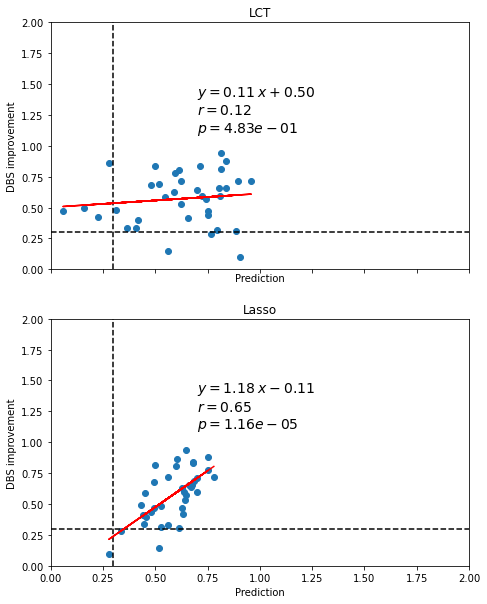

In [ ]:
util.eval_prediction(np.vstack((np.repeat(pre_imp,r),
                               results_ls,
                               )),
                               np.repeat(per_change,r),
                               ['LCT',
                                'Lasso',
                                ],(15,5))
plt.ylim([0,2])
plt.xlim([0,2])
plt.style.use('default')